# Import dependencies

### Basic utilities

In [1]:
import pathlib
import json
import csv
from pprint import pprint
import re

### Data structures

In [2]:
import numpy as np
import pandas as pd

### Plotting and visualization

In [57]:
from IPython.display import display, display_html, HTML
# import IPython.display as disp

import matplotlib.pyplot as plt

import seaborn as sns

### Import statistical packages

In [4]:
# statsmodels
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.stats import anova
from statsmodels.graphics.factorplots import interaction_plot

# scipy
from scipy import stats

### Set miscellaneous options

In [58]:
sns.set_style("whitegrid")
%matplotlib
%pylab inline

# Set the maximum number of columns for pandas to display
pd.set_option("display.max_columns",35)

Using matplotlib backend: MacOSX
Populating the interactive namespace from numpy and matplotlib


---

# Utility functions

### Define function to print pretty string output in HTML format

In [6]:
def mdprint(*objects, tag=None):
    raw_string = ' '.join([str(__) for __ in objects])
    
    if tag == 'h1':
        raw_string = '<h1>{}</h1>'.format(raw_string)
    elif tag == 'h2':
        raw_string = '<h2>{}</h2>'.format(raw_string)
    elif tag == 'h3':
        raw_string = '<h3>{}</h3>'.format(raw_string)
    elif tag == 'b':
        raw_string = '<b>{}</b>'.format(raw_string)
    
    display(HTML(raw_string))

verbose_printing = False
def vprint(*args, **kwargs):
    if verbose_printing:
        mdprint(*args, **kwargs)

---

# Data file input

### Load raw data files: `get_raw_data_files()`

- Define function to load the raw data files from the `/data/mazeexperiment/participant_data/` directory
- If the experiment script was started with a certain participant number on more than one occasion, subsequent occasions have a sequence number appended to the end. This function skips any files which are less than 1000 bytes, i.e. files which resulted from a false start of the experiment script

In [7]:
def get_raw_data_files(raw_data_folder):
    raw_data_files = raw_data_folder.glob('*.csv')
    
    chosen_files = list()
    for f in raw_data_files:
        # Check to see that file is larger than 1KB
        if f.stat().st_size > 1000:
            chosen_files.append(f)
            
    return chosen_files

### Reformat data files: `reformat_raw_data_files(raw_data_files)`

- Unescaped double quotes within the all_runtime column causes the data files to be misparsed.
- This function fixes that error to make these files parseable

In [8]:
def reformat_raw_data_files(raw_data_files, reformatted_data_folder):
    reformatted_files = list()
    
    for data_file in raw_data_files:
        # Fix name of file if it contains a sequence number at the end
        fixed_name = './{}/{}'.format(str(reformatted_data_folder), data_file.name)
        m = re.search(
            '(?P<directory>\./data/mazeexperiment/participant_data-reformatted/)' +
            '(?P<basename>RPACR_\d{3}_\d{4}-\d{2}-\d{2})' +
            '(?P<subscript>_\d+)?' +
            '(?P<extension>\.\w+)', fixed_name)
        m = m.groupdict()
        fixed_name = '{}{}{}'.format(m['directory'], m['basename'], m['extension'])
        fixed_file = pathlib.Path(fixed_name)
        
        # Open the raw input file and the output file for the reformatted data
        with data_file.open('r', encoding='utf-8') as in_file, fixed_file.open('w', encoding='utf-8') as out_file:
            # Loop through each line, fix the unescaped double quote, and write the line to a new file
            count = 0
            for line in in_file:
                if count == 0:
                    out_file.writelines(line)
                    continue

                fixed_line = line.replace('systemPlatform\': "windowsversion', 'systemPlatform\': ""windowsversion')
                fixed_line = fixed_line.replace('\')", \'experi', '\')"", \'experi')
                out_file.writelines(fixed_line)
                
        reformatted_files.append(fixed_file)
        
    return reformatted_files

### Parse files: `parse_raw_data_files(raw_data_files)`

The data files contain a serialized data structure that the `csv` module misinterprets as many columns. This function will combine those columns back into a list and write the result to new output files.

In [9]:
def parse_raw_data_files(raw_data_files, parsed_data_folder):
    
    parsed_files = list()
    
    for data_file in raw_data_files:
        
        # Open the data file
        with data_file.open('r', encoding='utf-8') as f:
            csvreader = csv.reader(f, delimiter=',', quotechar='"')
            data = []

            # Append the first (header) line to the list of lines
            data.append(next(csvreader)[:-1])
            
            # Correct a series of columns that the csv package parses as many individual columns
            # rather than as items within a serialized data structure
            for line in csvreader:
                data.append(line[:41] + [', '.join(line[41:83])] + line[83:-1])
                
        # Specify location of processed data file
        parsed_data_file = '{}/{}'.format(parsed_data_folder_name, data_file.name)
        parsed_data_file = pathlib.Path(parsed_data_file)
        
        # Write out processed version of data file
        with parsed_data_file.open('w', encoding='utf-8') as f:
            csvwriter = csv.writer(f, delimiter=',', quotechar='"')
            csvwriter.writerows(data)
            
        parsed_files.append(parsed_data_file)
        
    return parsed_files

### Load and process data files for analysis

- Check to see if folder containing reformatted and parsed data folders already exists, then load files
- Otherwise, reformat and parse the loaded raw data files

In [10]:
# Specify raw data folder
raw_data_folder_name = './data/mazeexperiment/participant_data/'
raw_data_folder = pathlib.Path(raw_data_folder_name)

# Create folder to hold reformatted data
reformatted_data_folder_name = './data/mazeexperiment/participant_data-reformatted/'
reformatted_data_folder = pathlib.Path(reformatted_data_folder_name)
reformatted_data_folder.mkdir(exist_ok=True)

# Create processed data folder
parsed_data_folder_name = './data/mazeexperiment/participant_data-processed/'
parsed_data_folder = pathlib.Path(parsed_data_folder_name)
parsed_data_folder.mkdir(exist_ok=True)

# Load raw data files from disk
raw_data_files = get_raw_data_files(raw_data_folder)
mdprint('Found {} raw data files'.format(len(raw_data_files)))

# Check to see if parsed data files already exist
parsed_data_files = list(parsed_data_folder.glob('*.csv'))

# If the number of files in the parsed data directory is equal to the number
# of raw data files, skip the reformatting and parsing steps
if len(parsed_data_files) == len(raw_data_files):
    mdprint('Raw data files have already been processed.', tag='b')
    mdprint('Skipping reformatting and parsing steps...')
    data_files = list(parsed_data_files)
else:
    mdprint('Now formatting and parsing raw data files for analysis...')
    
    raw_data_files = reformat_raw_data_files(raw_data_files, reformatted_data_folder)
    mdprint('Reformatted {} raw data files'.format(len(raw_data_files)))
    
    data_files = parse_raw_data_files(raw_data_files, parsed_data_folder)

mdprint('Loaded {} data files for analysis.'.format(len(data_files)))

---

# Prepare data structures for analysis

### Aggregate all participant IDs from the data file names

In [31]:
# Aggregate all participant ID numbers
participant_ids = []

# The index of where the participant ID number starts in the file name
pid_start = data_files[0].name.index('_') + 1
for data_file in data_files:
    # Extract the ID substring for the file name and convert it to an int
    pid = np.int16(data_file.name[pid_start:pid_start+3])
    participant_ids.append(pid)

### Create empty `participants` DataFrame

In [32]:
columns = [
    'data',
    'session_time',
    'version',
    'platform',
    'hostname',
    'psychopy_version',
    'window_size',
    'window_type'
]

participants = pd.DataFrame(
    index=pd.Index(participant_ids, name='participant'),
    columns=columns
)

### Load participant data into DataFrame

#### Load data from CSV file, excluding irrelevent columns

In [33]:
def load_csv_data(data):
    
    trials_df = pd.DataFrame.from_records(
        data[1:],
        columns=data[0],
        exclude=[
            'sentence', 'practice_block.thisRepN',
            'practice_block.thisTrialN', 'practice_block.thisN',
            'practice_block.thisIndex', 'proc_count',
            'exp_name', 'all_runtime',
            'frame_rate', 'pretrial_fixation'
        ]
    )

    
    # Exclude rows without a sentence block index, i.e. practice trials
    trials_df = trials_df.loc[trials_df['sentence_block.thisIndex'] != '']
    trials_df = trials_df.rename(columns={
        'sentence_trial.thisIndex': 'sentence_index',
        'sentence_block.thisN': 'sentence_order'
    })
    
    # Rename columns that don't have a valid Pythonic name
    renamed_cols = dict()
    for col in trials_df.axes[1]:
        if '.' in col:
            renamed_cols[col] = col.replace('.', '_')
            
    trials_df = trials_df.rename(columns=renamed_cols)
    
    # Convert numeric columns from string to int
    numeric_cols = [
        'target_pos', 'resp', 'resp_acc', 'sentence_index', 'sentence_order', 'critical_index',
        'condition', 'block_acc', 'sentence_number', 'resp_RT', 'block_RT'
    ]
    trials_df[numeric_cols] = trials_df[numeric_cols].apply(pd.to_numeric).astype(np.int, raise_on_error=False)
    
    return trials_df

#### Create a dataframe containing the individual item pairs in each sentence

In [34]:
def process_sentence_dataframe(trials_df):
    
    # Don't include the rows that contain block accuracy
    # Index DF by sentence number and pair index (2D)
    sentences_df = trials_df\
        .loc[np.isnan(trials_df['block_acc'])]\
        .set_index(['sentence_number', 'sentence_index'])\
        .filter([
            'pair_distractor', 'pair_correct',
            'target_pos', 'target_pos_verbose',
            'resp', 'resp_verbose',
            'resp_RT', 'resp_acc',
            'prev_pos', 'prev_resp'
        ])
    
    numeric_cols = ['target_pos', 'resp', 'resp_acc']
    sentences_df[numeric_cols] = sentences_df[numeric_cols].apply(pd.to_numeric).astype(np.int, raise_on_error=False)
    
    return sentences_df

#### Create a dataframe containing block-level information for each sentence

In [35]:
def process_block_dataframe(trials_df):
    
    # Include only rows that contain block accuracy
    # Index DF by sentence number

    block_df = trials_df\
        .loc[np.isfinite(trials_df['block_acc'])]\
        .set_index(['sentence_number'])\
        .filter([
            'sentence_order', 'full_sentence', 'critical_index',
            'critical_target', 'condition',
            'critical_distractor', 'block_acc',
            'block_RT'
        ])
    
    numeric_cols = ['sentence_order', 'critical_index', 'condition', 'block_acc', 'block_RT']
    block_df[numeric_cols] = block_df[numeric_cols].apply(pd.to_numeric).astype(np.int, raise_on_error=False)
    block_df['critical_index'] = block_df['critical_index'] - 1
    
    return block_df

#### Add condition labels to block-level information for each sentence

In [36]:
def process_condition_labels(block_df):
    
    # Define condition names and condition characteristics
    distractor_conditions = {1: 'both_sim', 2: 'orth_sim', 3: 'phon_sim', 4: 'both_dif'}
    phono_sim_condition = {1: True, 2: False, 3: True, 4: False}
    ortho_sim_condition = {1: True, 2: True, 3: False, 4: False}
    
    block_df['condition_label'] = block_df.apply(lambda row: distractor_conditions[row['condition']], axis=1)
    block_df['ortho_similarity'] = block_df.apply(lambda row: int(ortho_sim_condition[row['condition']]), axis=1)
    block_df['phono_similarity'] = block_df.apply(lambda row: int(phono_sim_condition[row['condition']]), axis=1)
    
    return block_df

#### Add stimuli characteristics to block-level information

In [42]:
def process_stim_characteristics(block_df, sentences_df):
    
    ####################################################################################
    # Load SUBTLEX character file
    ####################################################################################
    
    subtlex_chr_file = pathlib.Path('/Users/nick/github/orthophonology/data/subtlex-ch/SUBTLEX-CH-CHR.csv')
    
    with subtlex_chr_file.open('r') as f:
        subtlex_total_chr = next(f).split(': ')[1].replace(',', '').strip()
        subtlex_total_chr_contexts = next(f).split(': ')[1].replace(',', '').strip()
        
        subtlex_chr = pd.read_csv(f, sep='\t')
        
    subtlex_chr.columns = [
        'character', 'count', 'per_million', 'log_count',
        'context_count', 'context_percent', 'log_context_count'
    ]
    
    ####################################################################################
    # Load SUBTLEX word file
    ####################################################################################
    
    subtlex_word_file = pathlib.Path('/Users/nick/github/orthophonology/data/subtlex-ch/SUBTLEX-CH-WF.csv')
    
    with subtlex_word_file.open('r') as f:
        subtlex_total_word = next(f).split(': ')[1].replace(',', '').strip()
        subtlex_total_word_contexts = next(f).split(': ')[1].replace(',', '').strip()
        
        subtlex_word = pd.read_csv(f, sep='\t')
        
    subtlex_word.columns = [
        'word', 'count', 'per_million', 'log_count',
        'context_count', 'context_percent', 'log_context_count'
    ]

    ####################################################################################
    # Add frequency data to blocks
    ####################################################################################
    
    for ix, block in block_df.iterrows():
        
        ################################################################################
        # Check if the critical word was reached
        ################################################################################
        sentence = sentences_df.loc[ix]
        if block['critical_index'] in sentence.index:
            critical_pair = sentence.loc[block['critical_index']]
            block_df.loc[ix, 'critical_reached'] = 1
            
        else:
            block_df.loc[ix, 'critical_reached'] = 0
            continue
            
        
        ################################################################################
        # Process the target and distractor words
        ################################################################################
        block_df.loc[ix, 'critical_target_word'] = critical_pair['pair_correct'].replace(',', '').replace('.', '')
        block_df.loc[ix, 'target_length'] = len(block_df.loc[ix, 'critical_target_word'])
        
        block_df.loc[ix, 'critical_distractor_word'] = block_df.loc[ix, 'critical_distractor']
        
        # Isolate distractor character
        dist_word = block_df.loc[ix]['critical_distractor_word']
        targ_word = block_df.loc[ix]['critical_target_word']
        for charx in range(len(targ_word)):
            if dist_word[charx] != targ_word[charx]:
                block_df.loc[ix, 'critical_distractor'] = dist_word[charx]
                break
        else:
            raise ValueError('Could not isolate distractor character')
        
        
        ################################################################################
        # Get the frequencies
        ################################################################################
        # Get frequency of target character
        if len(subtlex_chr.loc[subtlex_chr['character'] == block_df.loc[ix, 'critical_target']]):
            block_df.loc[ix, 'critical_target_freq']\
                = np.float(subtlex_chr.loc[subtlex_chr['character'] == block_df.loc[ix, 'critical_target']]['log_count'])
        else:
            block_df.loc[ix, 'critical_target_freq'] = 0
        
        # Get frequency of distractor character
        if len(subtlex_chr.loc[subtlex_chr['character'] == block_df.loc[ix, 'critical_distractor']]):
            block_df.loc[ix, 'critical_distractor_freq']\
              = np.float(subtlex_chr.loc[subtlex_chr['character'] == block_df.loc[ix, 'critical_distractor']]['log_count'])
        else:
            block_df.loc[ix, 'critical_distractor_freq'] = 0
            
        
        # Get frequency of target word
        if len(subtlex_word.loc[subtlex_word['word']==block_df.loc[ix,'critical_target_word']]):
            block_df.loc[ix, 'critical_target_word_freq'] = np.float(
                subtlex_word.loc[subtlex_word['word']==block_df.loc[ix,'critical_target_word']]['log_count']
            )
        
        else:
            block_df.loc[ix, 'critical_target_word_freq'] = 0
            
        
        # Get frequency of distractor word
        if len(subtlex_word.loc[subtlex_word['word']==block_df.loc[ix,'critical_distractor_word']]):    
            block_df.loc[ix, 'critical_distractor_word_freq'] = np.float(
                subtlex_word.loc[subtlex_word['word']==block_df.loc[ix,'critical_distractor_word']]['log_count']
            )
        
        else:
            block_df.loc[ix, 'critical_distractor_word_freq'] = 0
        
    # Readjust column ordering
    cols = [
        'sentence_order', 'full_sentence', 'critical_reached',
        'critical_index', 'critical_target', 'critical_distractor',
        'critical_target_word', 'critical_distractor_word', 'target_length',
        'condition', 'condition_label', 'ortho_similarity', 'phono_similarity',
        'critical_target_freq', 'critical_distractor_freq',
        'critical_target_word_freq', 'critical_distractor_word_freq',
        'block_acc', 'block_RT'
    ]
    block_df = block_df[cols]
    
    return block_df
    
    

#### Create a combined dataframe containing pair- and block-level information

In [38]:
# def combine_dataframes(block_df, sentences_df):
    
    
        
#     return combined_df

#### Process the data files

In [43]:
count = 0
for data_file in data_files:
    count += 1

    with data_file.open('r') as f:
        csvreader = csv.reader(f, delimiter=',')
        data = list(csvreader)
    
    trials_df    = load_csv_data(data)
    
    sentences_df = process_sentence_dataframe(trials_df)
    
    block_df     = process_block_dataframe(trials_df)
    block_df     = process_condition_labels(block_df)
    block_df     = process_stim_characteristics(block_df, sentences_df)
    
    # combined_df  = combine_dataframes(block_df, sentences_df)
    combined_df = pd.DataFrame(
        index=pd.Index(np.arange(1, len(block_df)+1), name='sentence_number'),
        columns=['block', 'sentence']
    )
    
    for row in combined_df.iterrows():
        row[1]['block'] = block_df.loc[row[0]]
        row[1]['sentence'] = sentences_df.loc[row[0]]
        
    ####################################################################################
    # Add all data to participants dataframe
    ####################################################################################
    
    # Get view of participant's row from participant dataframe
    participant_row = participants.loc[np.int(trials_df.iloc[0]['participant'])]

    # Add data to row
    participant_row['data'] = combined_df
    
    # Set participant-level information within row
    participant_row['session_time'] = '{} {}'.format(trials_df.iloc[0]['date'], trials_df.iloc[0]['session_start'])
    
    included_cols = ['version', 'platform', 'hostname', 'psychopy_version', 'window_size', 'window_type']
    participant_row[included_cols] = trials_df.iloc[0][included_cols]
    
    disp.clear_output(wait=True)
    mdprint('Number of rows processed: {: >2}'.format(count))
    
disp.clear_output(wait=True)
mdprint('Columns in participants:', tag='b')
mdprint(',&nbsp;&nbsp;&nbsp;'.join(list(participants.axes[1])))

### Create flat dataframe with all participant data

In [44]:
# The columns that identify participant, sentence number, and pair in the sentence
index_columns = ['participant', 'sentence_number', 'sentence_index']

# The columns that carry block-level data
block_cols = list(participants.iloc[0]['data'].iloc[0]['block'].axes[0])
block_cols.remove('full_sentence')

# The columns that carry pair-level data
sentence_cols = list(participants.iloc[0]['data'].iloc[1]['sentence'].axes[1])

# Merged list of all the columns
flat_columns = index_columns + block_cols + sentence_cols

####################################################################################
# Count the number of individual trials to pre-allocate the dataframe
####################################################################################
    
allocate_count = 0

# Iterate through each participant
for p_id in participants.axes[0]:
    
    # Iterate through the sentences for each participant
    for s_id in participants.loc[p_id]['data'].axes[0]:
        
        # Add the number of words seen in each sentence to the allocation count
        allocate_count += len(participants.loc[p_id]['data'].loc[s_id]['sentence'].axes[0])

# Pre-allocate the flat dataframe
participants_flat = pd.DataFrame(
    columns=flat_columns,
    index=pd.Index(np.arange(allocate_count)),
    dtype=np.int64
)
####################################################################################
# Iterate through each item pair and add data to flat dataframe
####################################################################################

ix = 0

# Iterate through each participant
for p_id in participants.axes[0]:
    
    # Iterate through each sentence completed by the participant
    for s_id in participants.loc[p_id]['data'].axes[0]:

        # Collect the block- and sentence-level data all at once
        # to avoid repeated called to the same row
        block_data = participants.loc[p_id]['data'].loc[s_id]['block'][block_cols]
        sentence_data = participants.loc[p_id]['data'].loc[s_id]['sentence']
        
        # Iterate through each item pair in each sentence
        for s_ix in participants.loc[p_id]['data'].loc[s_id]['sentence'].axes[0]:

            # Assign the index columns
            participants_flat.iloc[ix]['participant'] = p_id
            participants_flat.iloc[ix]['sentence_number'] = s_id
            participants_flat.iloc[ix]['sentence_index'] = s_ix
            
            # Assign the block- and sentence-level data
            participants_flat.iloc[ix][block_cols] = block_data
            participants_flat.iloc[ix][sentence_cols] = sentence_data.iloc[s_ix][sentence_cols]
                
            ix += 1
        
            if ix % 50 == 0:
                disp.clear_output(wait=True)
                print('Completed processing of participant #{}\n'
                      'Number of rows processed: {: >6}\n'
                      'Percentage of rows done:  {: >7.2%}'.format(p_id, ix, (ix / allocate_count))
                )

disp.clear_output(wait=True)
print('Finished processing data from {} participants\n'
      'Number of rows processed: {: >6}\n'
      'Percentage of rows done:  {: >7.2%}\n'.format(participants_flat.iloc[ix-1]['participant']-100, ix, (ix / allocate_count))
)

cols = list(participants_flat.axes[1])
cols_split = list()
curr = list()
for i in range(1, len(cols)+1):
    curr.append(cols[i-1])
    
    if i % 6 == 0:
        cols_split.append(',&nbsp;&nbsp;&nbsp;'.join(curr))
        curr = list()        
cols_split.append(',&nbsp;&nbsp;&nbsp;'.join(curr))
mdprint('Columns in participants_flat:', tag='b')
for cols in cols_split:
    mdprint('&nbsp;&nbsp;&nbsp;&nbsp;', cols)

Finished processing data from 53 participants
Number of rows processed:  40247
Percentage of rows done:  100.00%



/Users/nick/.pyenv/versions/anaconda3-4.3.1/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/Users/nick/.pyenv/versions/anaconda3-4.3.1/lib/python3.6/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/nick/.pyenv/versions/anaconda3-4.3.1/lib/python3.6/site-packages/pandas/core/frame.py:2440: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = val

53


,critical_reached,block_acc
participant,,
120,59,53.125000
122,54,42.708333
123,52,42.708333


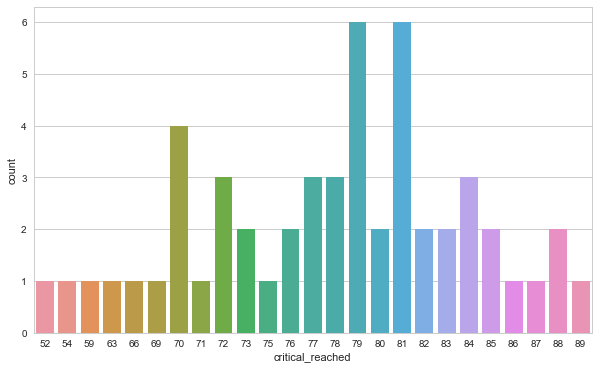

In [199]:
block = participants_flat.loc[participants_flat['sentence_index'] == 0]

block['critical_reached'] = block['critical_reached'] * 100
block['block_acc'] = block['block_acc'] * 100

block[['critical_reached', 'block_acc']] = block[['critical_reached', 'block_acc']].apply(pd.to_numeric).astype(np.int)

block = block[['participant', 'critical_reached', 'block_acc']].groupby('participant').mean()
block['critical_reached'] = block['critical_reached'].apply(pd.to_numeric).astype(np.int)
# display(block['critical_reached'])

print(len(block))
eliminated = block.loc[block['critical_reached'] < np.mean(block['critical_reached']) - np.std(block['critical_reached'])*2]

display(eliminated)

figsize(10,6)
p = sns.countplot(block['critical_reached'])
fig = p.get_figure()

/Users/nick/.pyenv/versions/anaconda3-4.3.1/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


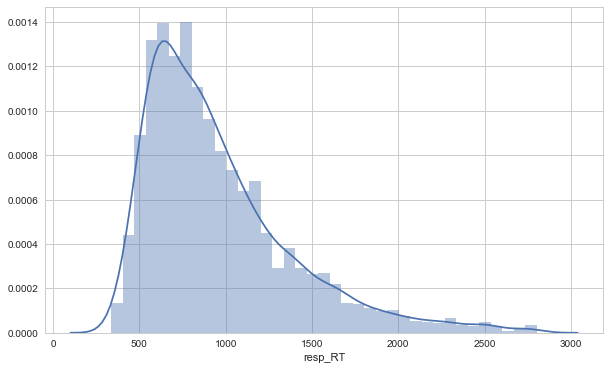

In [128]:
criticals_only = participants_flat.loc[participants_flat['sentence_index'] == participants_flat['critical_index']]
full_count = len(criticals_only)
resp_cutoff = np.int(np.mean(criticals_only['resp_RT']) + np.std(criticals_only['resp_RT'])*3)
criticals_only = criticals_only.loc[(criticals_only['resp_RT'] < resp_cutoff) & (criticals_only['resp_RT'] > 300)]
subset_count = len(criticals_only)

criticals_only['resp_RT'] = criticals_only['resp_RT'].astype(np.int)

mdprint(
    'Removal cutoff:', resp_cutoff,
    '<br>Full set:', full_count,
    '<br>Subset:', subset_count,
    '<br>Percentage removed: {:.2%}'.format((full_count-subset_count)/full_count),
    tag='h1'
)


figsize(10,6)
p = sns.distplot(criticals_only['resp_RT'])
fig = p.get_figure()
fig.savefig('descriptives/resp_RT.png')

/Users/nick/.pyenv/versions/anaconda3-4.3.1/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


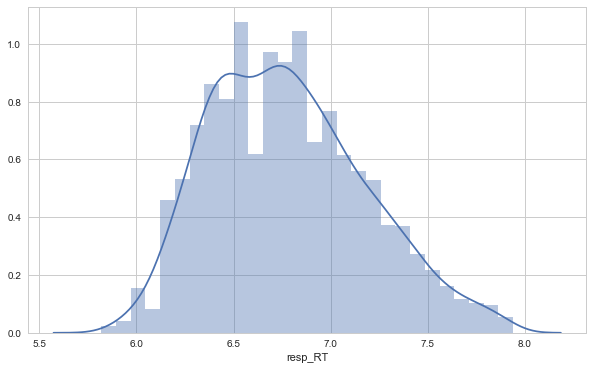

In [129]:
p = sns.distplot(np.log(criticals_only['resp_RT']))
fig = p.get_figure()
fig.savefig('descriptives/log_resp_RT.png')

/Users/nick/.pyenv/versions/anaconda3-4.3.1/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


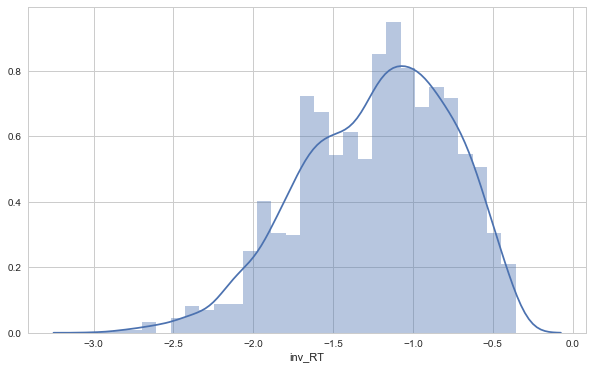

In [132]:
criticals_only['inv_RT'] = -1000/criticals_only['resp_RT']

p = sns.distplot(criticals_only['inv_RT'])
fig = p.get_figure()
fig.savefig('descriptives/inverse_resp_RT.png')

In [143]:
criticals_only['ortho_center'] = criticals_only.apply(lambda row: (-1 if row['ortho_similarity'] == 0 else 1), axis=1)
criticals_only['phono_center'] = criticals_only.apply(lambda row: (-1 if row['phono_similarity'] == 0 else 1), axis=1)

display(criticals_only[:10][['inv_RT', 'condition', 'ortho_center', 'phono_center']])


,inv_RT,condition,ortho_center,phono_center
9,-1.440922,3,-1,1
20,-2.785515,4,-1,-1
26,-0.593824,2,1,-1
46,-1.054852,4,-1,-1
56,-1.582278,3,-1,1
63,-1.697793,4,-1,-1
72,-2.159827,2,1,-1
93,-0.650618,1,1,1
99,-1.901141,2,1,-1
106,-2.066116,4,-1,-1


In [169]:
md = smf.mixedlm(
    "inv_RT ~ "
    "ortho_center*phono_center +"
    "(1 + ortho_center*phono_center|C(participant))",
#     "(1 + (ortho_center*phono_center):C(sentence_number))",
    criticals_only, groups=criticals_only[['participant']])
mdf = md.fit()
mdf.summary()

PatsyError: Error evaluating factor: TypeError: cannot compare a dtyped [int64] array with a scalar of type [bool]
    inv_RT ~ ortho_center*phono_center +(1 + ortho_center*phono_center|C(participant))
                                                          ^^^^^^^^^^^^^^^^^^^^^^^^^^^

In [106]:
participants_flat.loc[participants_flat['sentence_index'] == participants_flat['critical_index']].to_csv('output/participants_flat-critical_only.csv', sep='\t')

In [103]:
participants_flat[['participant', 'block_acc']].apply(pd.to_numeric).astype(np.float, raise_on_error=False).groupby('participant').describe().loc[121]

,block_acc
count,769.000000
mean,0.819246
std,0.385065
min,0.000000
25%,1.000000
50%,1.000000
75%,1.000000
max,1.000000


---

# Compute descriptive statistics

In [99]:
def compute_sentence_performance():
    
    sentence_performance = participants_flat.loc[
        participants_flat['sentence_index'] == 0,
        ['participant', 'sentence_number', 'block_acc', 'critical_reached']
    ]

    pids = pd.unique(sentence_performance['participant'])
    
    performance = pd.DataFrame(
        columns=['block_acc', 'critical_reached'],
        index=pd.Index(pids, name='participant'),
        dtype=np.float64
    )

    for pid in pids:
        completed_sentences = sentence_performance.loc[
            (sentence_performance['participant'] == pid) &
            (sentence_performance['block_acc'] == 1)
        ]['sentence_number']
        
        reached_criticals = sentence_performance.loc[
            (sentence_performance['participant'] == pid) &
            (sentence_performance['critical_reached'] == 1)
        ]['sentence_number']
        
        performance.loc[pid]['block_acc'] = (completed_sentences.count() / 96 * 100)
        performance.loc[pid]['critical_reached'] = (reached_criticals.count() / 96 * 100)
        
#     display(performance)
        
    performance = performance.apply(pd.to_numeric).astype(np.float, raise_on_error=False)
        
    display(performance['block_acc'].describe())
    display(performance['critical_reached'].describe())
    
    return performance
                
performance_by_part = compute_sentence_performance()

def compute_sentence_statistics():
    sentence_performance = participants_flat.loc[
        participants_flat['sentence_index'] == 0,
        ['participant', 'sentence_number', 'block_acc', 'critical_reached']
    ]
    
    sids = pd.unique(sentence_performance['sentence_number'])
    
    performance = pd.DataFrame(
        columns=['block_acc', 'critical_reached'],
        index=pd.Index(sids, name='sentence_number'),
        dtype=np.float64
    )
    
    for sid in sids:
        completed_sentences = sentence_performance.loc[
            (sentence_performance['sentence_number'] == sid) &
            (sentence_performance['block_acc'] == 1)
        ]['participant']
        
        reached_criticals = sentence_performance.loc[
            (sentence_performance['sentence_number'] == sid) &
            (sentence_performance['critical_reached'] == 1)
        ]['participant']
        
        performance.loc[sid]['block_acc'] = (completed_sentences.count() / 53 * 100)
        performance.loc[sid]['critical_reached'] = (reached_criticals.count() / 53 * 100)
        
    performance = performance.apply(pd.to_numeric).astype(np.float, raise_on_error=False)
        
    display(performance['block_acc'].describe())
    display(performance['critical_reached'].describe())
    
    return performance

performance_by_sent = compute_sentence_statistics()

def compute_conditions():
    performance = participants_flat.loc[
        participants_flat['sentence_index'] == participants_flat['critical_index'],
        ['participant', 'sentence_number', 'block_acc', 'critical_reached', 'condition', 'resp_RT', 'resp_acc', 'prev_pos']
    ]
    performance = performance.apply(pd.to_numeric).astype(np.float, raise_on_error=False)
    
    return performance
    
#     sids = pd.unique(sentence_performance['sentence_number'])
    
#     performance = pd.DataFrame(
#         columns=['block_acc', 'critical_reached'],
#         index=pd.Index(sids, name='sentence_number'),
#         dtype=np.float64
#     )
    
#     for sid in sids:
#         completed_sentences = sentence_performance.loc[
#             (sentence_performance['sentence_number'] == sid) &
#             (sentence_performance['block_acc'] == 1)
#         ]['participant']
        
#         reached_criticals = sentence_performance.loc[
#             (sentence_performance['sentence_number'] == sid) &
#             (sentence_performance['critical_reached'] == 1)
#         ]['participant']
        
#         performance.loc[sid]['block_acc'] = (completed_sentences.count() / 53 * 100)
#         performance.loc[sid]['critical_reached'] = (reached_criticals.count() / 53 * 100)
        
#     performance = performance.apply(pd.to_numeric).astype(np.float, raise_on_error=False)
        
#     display(performance['block_acc'].describe())
#     display(performance['critical_reached'].describe())
    
#     return performance

condition_performance = compute_conditions()
grouped = condition_performance.groupby('condition').describe()
grouped = grouped.loc[grouped.index.get_level_values(1) != 'count']
display(grouped)

count    53.000000
mean     71.953616
std       9.110517
min      42.708333
25%      67.708333
50%      72.916667
75%      78.125000
max      86.458333
Name: block_acc, dtype: float64

count    53.000000
mean     77.338836
std       7.924954
min      52.083333
25%      72.916667
50%      79.166667
75%      82.291667
max      89.583333
Name: critical_reached, dtype: float64

count     96.000000
mean      71.953616
std       20.553543
min        9.433962
25%       61.320755
50%       80.188679
75%       86.792453
max      100.000000
Name: block_acc, dtype: float64

count     96.000000
mean      77.338836
std       19.474836
min       11.320755
25%       69.339623
50%       83.018868
75%       90.566038
max      100.000000
Name: critical_reached, dtype: float64

block_acc  critical_reached  participant  prev_pos  \
condition                                                            
1.0       mean   0.922543               1.0   126.860116  0.495906   
          std    0.267469               0.0    15.453562  0.500276   
          min    0.000000               1.0   101.000000  0.000000   
          25%    1.000000               1.0   113.000000  0.000000   
          50%    1.000000               1.0   127.000000  0.000000   
          75%    1.000000               1.0   140.000000  1.000000   
          max    1.000000               1.0   153.000000  1.000000   
2.0       mean   0.934678               1.0   126.778098  0.488802   
          std    0.247212               0.0    15.632736  0.500118   
          min    0.000000               1.0   101.000000  0.000000   
          25%    1.000000               1.0   113.000000  0.000000   
          50%    1.000000               1.0   127.000000  0.000000   
          75%    1.000000               1.0   140.000000  1.000000   
          max    1.000000               1.0   153.000000  1.000000   
3.0       mean   0.924436               1.0   126.835132  0.491036   
          std    0.264429               0.0    15.458364  0.500169   
          min    0.000000               1.0   101.000000  0.000000   
          25%    1.000000               1.0   113.000000  0.000000   
          50%    1.000000               1.0   127.000000  0.000000   
          75%    1.000000               1.0   140.000000  1.000000   
          max    1.000000               1.0   153.000000  1.000000   
4.0       mean   0.938614               1.0   126.703960  0.476908   
          std    0.240156               0.0    15.504483  0.499717   
          min    0.000000               1.0   101.000000  0.000000   
          25%    1.000000               1.0   113.000000  0.000000   
          50%    1.000000               1.0   127.000000  0.000000   
          75%    1.000000               1.0   140.000000  1.000000   
          max    1.000000               1.0   153.000000  1.000000   

                     resp_RT  resp_acc  sentence_number  
condition                                                
1.0       mean   1083.355341  0.965318        49.684393  
          std     744.978226  0.183079        27.886568  
          min       0.210000  0.000000         1.000000  
          25%     653.620000  1.000000        27.000000  
          50%     884.480000  1.000000        51.000000  
          75%    1222.460000  1.000000        74.000000  
          max    7032.840000  1.000000        96.000000  
2.0       mean   1034.570288  0.972142        49.424592  
          std     555.906863  0.164644        27.192235  
          min       0.160000  0.000000         1.000000  
          25%     654.740000  1.000000        27.000000  
          50%     885.530000  1.000000        50.000000  
          75%    1222.220000  1.000000        73.000000  
          max    4929.940000  1.000000        96.000000  
3.0       mean    990.655849  0.974485        49.396467  
          std     616.122673  0.157761        26.847489  
          min     358.380000  0.000000         1.000000  
          25%     633.110000  1.000000        27.500000  
          50%     843.180000  1.000000        50.000000  
          75%    1138.130000  1.000000        72.000000  
          max   11604.640000  1.000000        96.000000  
4.0       mean    933.681267  0.980198        50.333663  
          std     469.646123  0.139388        27.442138  
          min       0.180000  0.000000         1.000000  
          25%     632.372500  1.000000        29.000000  
          50%     822.220000  1.000000        51.000000  
          75%    1076.325000  1.000000        74.000000  
          max    5921.400000  1.000000        96.000000

       participant  sentence_number  block_acc  critical_reached  condition  \
36           101.0              5.0        1.0               1.0        1.0   
93           101.0             13.0        1.0               1.0        1.0   
149          101.0             20.0        1.0               1.0        1.0   
211          101.0             26.0        1.0               1.0        1.0   
241          101.0             29.0        1.0               1.0        1.0   
283          101.0             34.0        1.0               1.0        1.0   
305          101.0             37.0        1.0               1.0        1.0   
358          101.0             42.0        1.0               1.0        1.0   
444          101.0             54.0        0.0               1.0        1.0   
452          101.0             55.0        1.0               1.0        1.0   
563          101.0             68.0        1.0               1.0        1.0   
589          101.0             71.0        1.0      

/Users/nick/.pyenv/versions/anaconda3-4.3.1/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


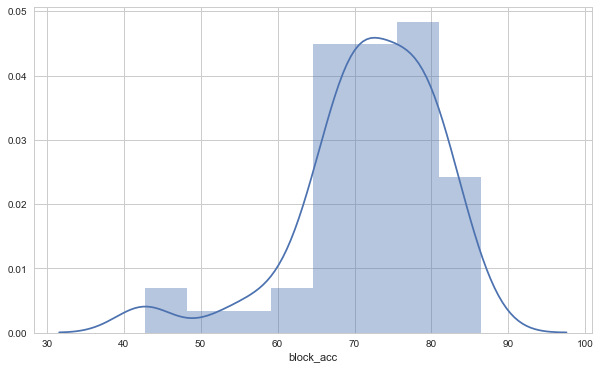

In [64]:
figsize(10,6)
p = sns.distplot(performance_by_part['block_acc'])
fig = p.get_figure()
fig.savefig('descriptives/block_acc.png')

/Users/nick/.pyenv/versions/anaconda3-4.3.1/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


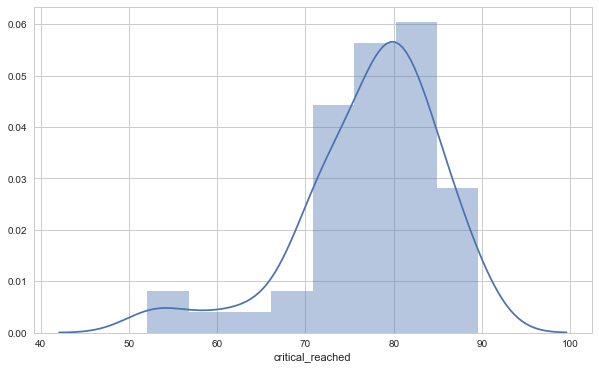

In [63]:
p = sns.distplot(performance_by_part['critical_reached'])
fig = p.get_figure()
fig.savefig('descriptives/critical_reached.png')

/Users/nick/.pyenv/versions/anaconda3-4.3.1/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


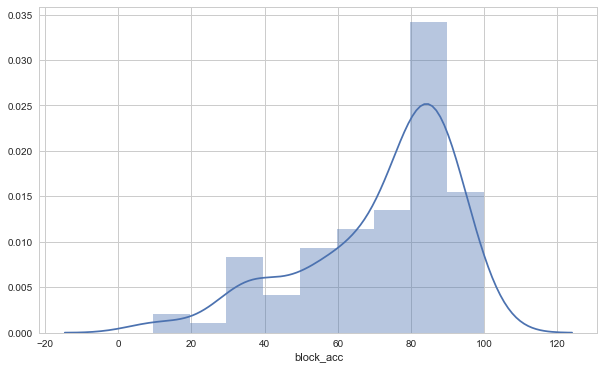

In [68]:
figsize(10,6)
p = sns.distplot(performance_by_sent['block_acc'])
fig = p.get_figure()
fig.savefig('descriptives/sent_block_acc.png')

/Users/nick/.pyenv/versions/anaconda3-4.3.1/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


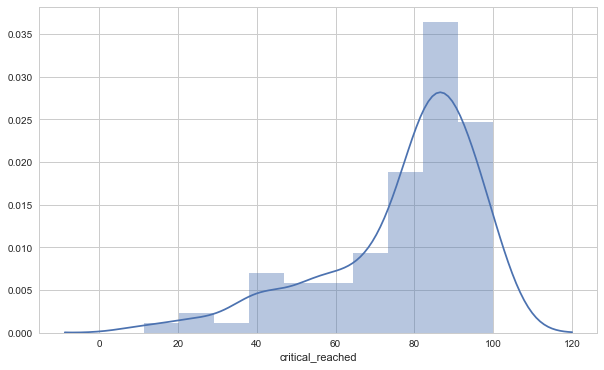

In [69]:
p = sns.distplot(performance_by_sent['critical_reached'])
fig = p.get_figure()
fig.savefig('descriptives/sent_critical_reached.png')

In [ ]:
p = sns.distplot(condition_performance['critical_reached'])
fig = p.get_figure()
fig.savefig('descriptives/sent_critical_reached.png')